In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import tft2d
import timm
import PIL.Image
from types import SimpleNamespace
from torchvision.transforms.v2 import (
    Compose, Resize, CenterCrop, Normalize, 
    PILToTensor, ToPILImage)
from datasets import load_dataset
from fastprogress.fastprogress import progress_bar

/home/dgj335/.local/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
device = 'cuda'
config = SimpleNamespace()
config.batch_size = 512
config.num_workers = 12
config.image_size = 288
config.crop_size = 256
config.channels = 3

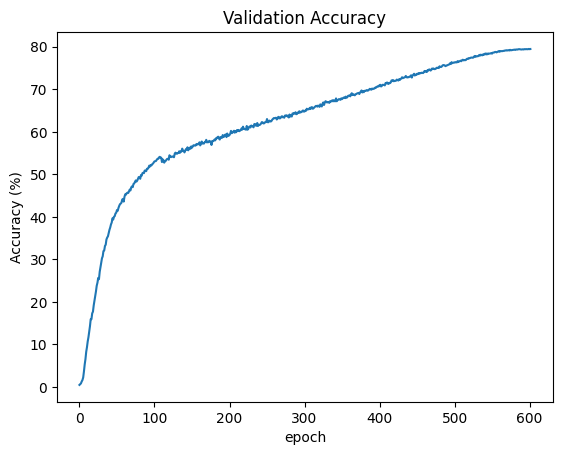

In [3]:
checkpoint = torch.load("output/train/20241220-120937-tft2d-256/checkpoint-586.pth.tar",map_location='cpu',weights_only=False)
data = pd.read_csv('output/train/20241220-120937-tft2d-256/summary.csv')
data.plot(x='epoch', y='eval_top1', legend=False, title='Validation Accuracy')
plt.ylabel('Accuracy (%)')

model = timm.create_model(
    'tft2d',
    pretrained=False,   
    num_classes=1000,   # or the correct number from training
    in_chans=3
)
missing, unexpected = model.load_state_dict(checkpoint['state_dict'], strict=True)
model.to(device)
model.eval();

In [4]:
dataset_valid = load_dataset('timm/imagenet-1k-wds',split='validation')

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

In [5]:
cent_crop = Compose([
    Resize(config.image_size,interpolation=PIL.Image.Resampling.LANCZOS),
    CenterCrop(size=config.crop_size),
    PILToTensor()
])

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = cent_crop(sample['jpg'].convert("RGB"))
    return (x,y)

In [6]:
inet_normalize = Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [7]:
n_correct = 0 
data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    drop_last=False,
    pin_memory=True,
    collate_fn=valid_collate_fn
)
pb_valid = progress_bar(data_loader_valid)
for i_batch, (x, y) in enumerate(pb_valid):
    y = y.to(torch.long).to(device)
    x = x.to(device).to(torch.float)/255
    x = inet_normalize(x)
    with torch.no_grad(), torch.amp.autocast(device_type=device):
        logits = model(x)
    n_correct += torch.sum(logits.argmax(dim=1) == y).item()

n_correct/dataset_valid.num_rows

0.79412